In [3]:
import os
import pandas as pd
import numpy as np
import librosa
from tqdm import tqdm

In [9]:
df = pd.read_csv("meta.csv")

In [11]:
df.sample(5)


,file,speaker,label
24453,24453.wav,Christopher Hitchens,spoof
2341,2341.wav,Barack Obama,bona-fide
21696,21696.wav,Alec Guinness,bona-fide
29619,29619.wav,Norm MacDonald,spoof
22918,22918.wav,Winston Churchill,bona-fide


In [12]:
df = df.drop("speaker",axis = 1)

In [13]:
df.sample(5)

,file,label
5749,5749.wav,bona-fide
3560,3560.wav,bona-fide
18368,18368.wav,spoof
21740,21740.wav,bona-fide
15225,15225.wav,bona-fide


In [14]:
label_mapping = {'bona-fide': 0, 'spoof': 1}
df['label_code'] = df['label'].map(label_mapping)

In [15]:
df.sample(5)

,file,label,label_code
17931,17931.wav,bona-fide,0
2136,2136.wav,bona-fide,0
7008,7008.wav,bona-fide,0
9382,9382.wav,bona-fide,0
26442,26442.wav,spoof,1


In [16]:
AUDIO_ROOT_PATH = "real"
def extract_physics_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        
        rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85))
        centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc_means = np.mean(mfcc, axis=1)
        
        return {
            "rolloff": rolloff,
            "centroid": centroid,
            "zcr": zcr,
            **{f"mfcc_{i}": m for i, m in enumerate(mfcc_means)}
        }
    except Exception as e:
        return None

In [17]:


print("Extracting features... this might take a while!")
features_list = []

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    filename = row['file']
    
    full_path = os.path.join(AUDIO_ROOT_PATH, filename)
    
    data = extract_physics_features(full_path)
    
    if data:
        features_list.append(data)
    else:
        features_list.append({k: np.nan for k in ["rolloff", "centroid", "zcr"]})

features_df = pd.DataFrame(features_list)

final_df = pd.concat([df, features_df], axis=1)

final_df = final_df.dropna()

final_df.to_csv("training_data_final.csv", index=False)

Extracting features... this might take a while!


100%|████████████████████████████████████████████████████████████████████████████| 31779/31779 [25:57<00:00, 20.41it/s]


In [18]:
final_df.sample(5)

,file,label,label_code,rolloff,centroid,zcr,mfcc_0,mfcc_1,mfcc_2,mfcc_3,...,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19
10657,10657.wav,bona-fide,0,1968.750000,1010.523152,0.048727,-351.203339,125.086166,7.066954,24.496622,...,-13.292561,-1.148798,-10.064635,-1.957543,-3.974291,-7.742030,-3.508900,-4.947564,-13.834888,-4.531219
3547,3547.wav,spoof,1,2398.097826,1369.477210,0.155160,-397.521790,134.398941,11.072885,15.913781,...,0.254082,-10.182762,-6.952436,-1.444799,-10.982661,-2.678550,-7.015907,-9.800298,-6.443634,-5.256656
24020,24020.wav,spoof,1,2783.159722,1475.754488,0.099099,-355.874634,84.702393,10.465854,38.091553,...,-3.226431,0.145320,-5.793239,2.374304,-12.926272,-0.859104,-12.297477,-1.437539,-5.581086,-1.260346
27748,27748.wav,bona-fide,0,2489.304315,1269.418862,0.069464,-364.221344,96.083633,19.197414,29.925526,...,-21.232187,-0.789002,-10.765438,-3.202377,-10.073404,-9.668330,-4.189547,-6.812708,-14.903920,-5.178642
6089,6089.wav,spoof,1,2639.531250,1414.728820,0.142371,-365.517975,118.294220,-38.776516,29.606583,...,-5.033455,-4.376585,10.730816,-0.676248,-13.846108,8.300477,-8.808736,-9.257281,5.060131,-5.758965


exploratory data analysis

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("training_data_final.csv")

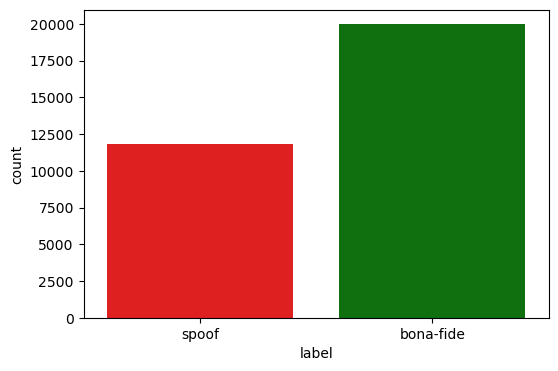

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', hue='label', palette=['red','green'], legend=False)
plt.show()

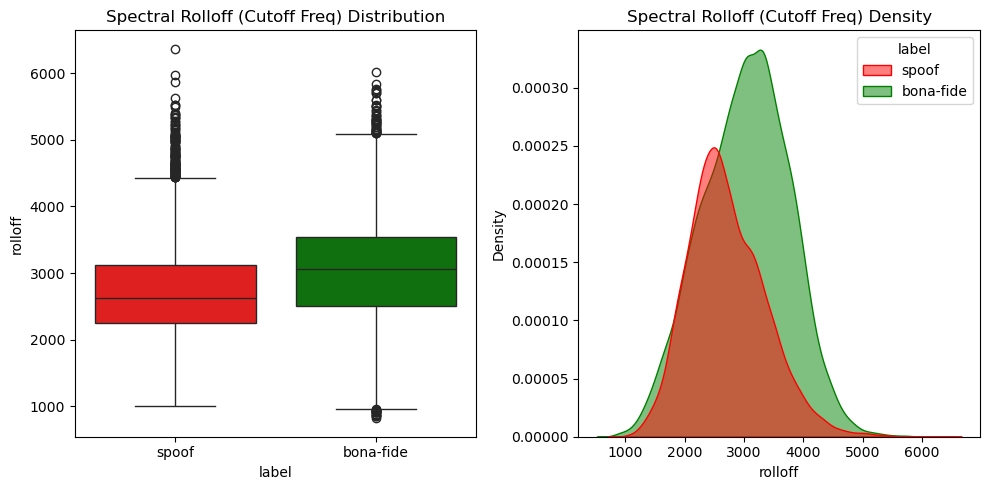

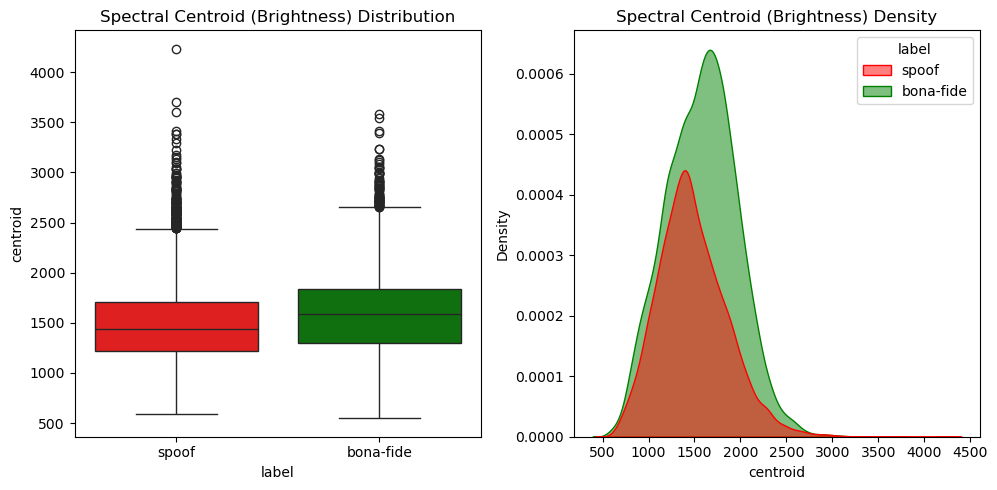

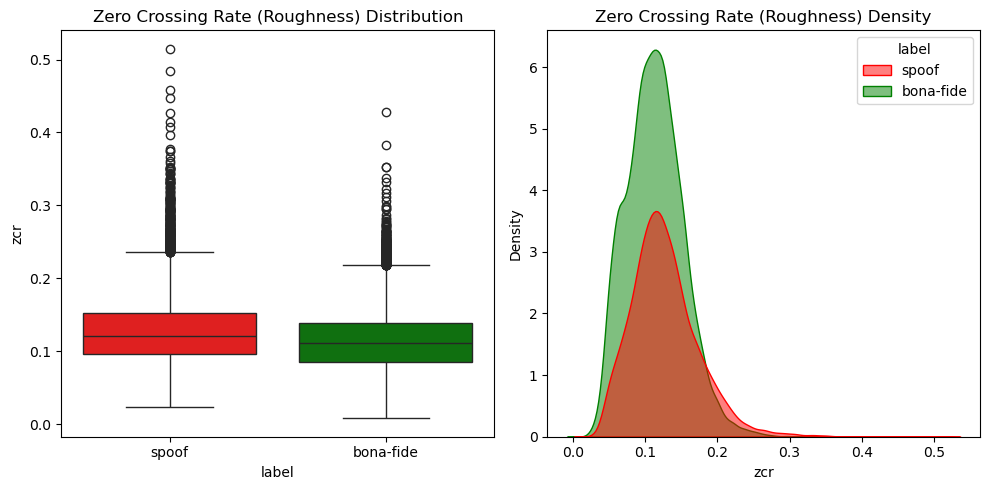

In [7]:
physics_features = ['rolloff', 'centroid', 'zcr']
feature_names = ['Spectral Rolloff (Cutoff Freq)', 'Spectral Centroid (Brightness)', 'Zero Crossing Rate (Roughness)']

for feature, name in zip(physics_features, feature_names):
    plt.figure(figsize=(10, 5))
    
    # A. Boxplot (Fixed)
    plt.subplot(1, 2, 1)
    # FIX: Added hue='label' and legend=False
    sns.boxplot(data=df, x='label', y=feature, hue='label', palette=['red', 'green'], legend=False)
    plt.title(f"{name} Distribution")
    
    # B. KDE Plot (Already correct, but keeping for completeness)
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df, x=feature, hue='label', fill=True, palette=['red', 'green'], alpha=0.5)
    plt.title(f"{name} Density")
    
    plt.tight_layout()
    plt.show()

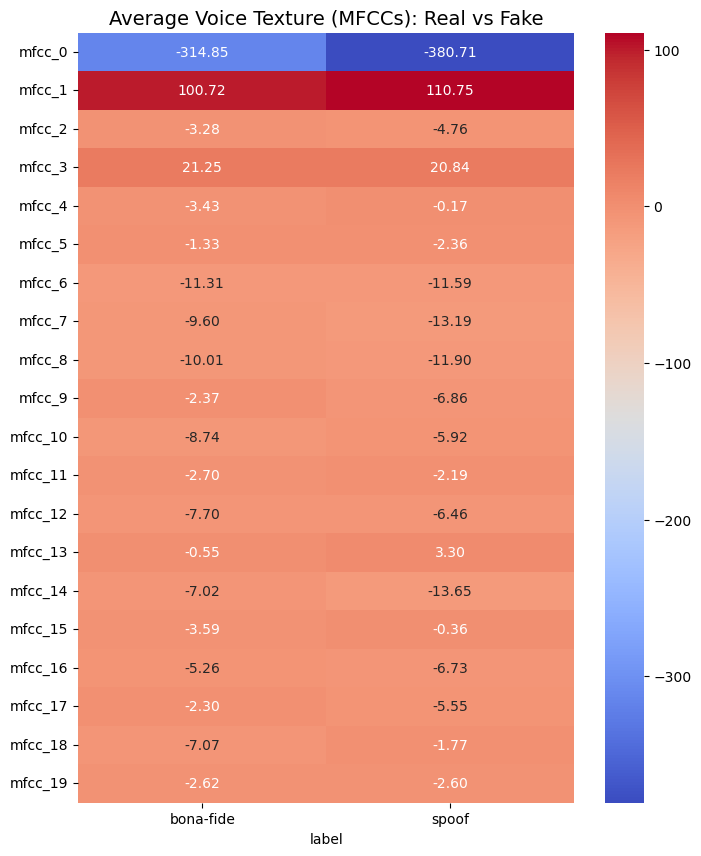

In [8]:
mfcc_cols = [c for c in df.columns if 'mfcc' in c]
mfcc_avg = df.groupby('label')[mfcc_cols].mean().transpose()

plt.figure(figsize=(8, 10))
sns.heatmap(mfcc_avg, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Average Voice Texture (MFCCs): Real vs Fake", fontsize=14)
plt.show()

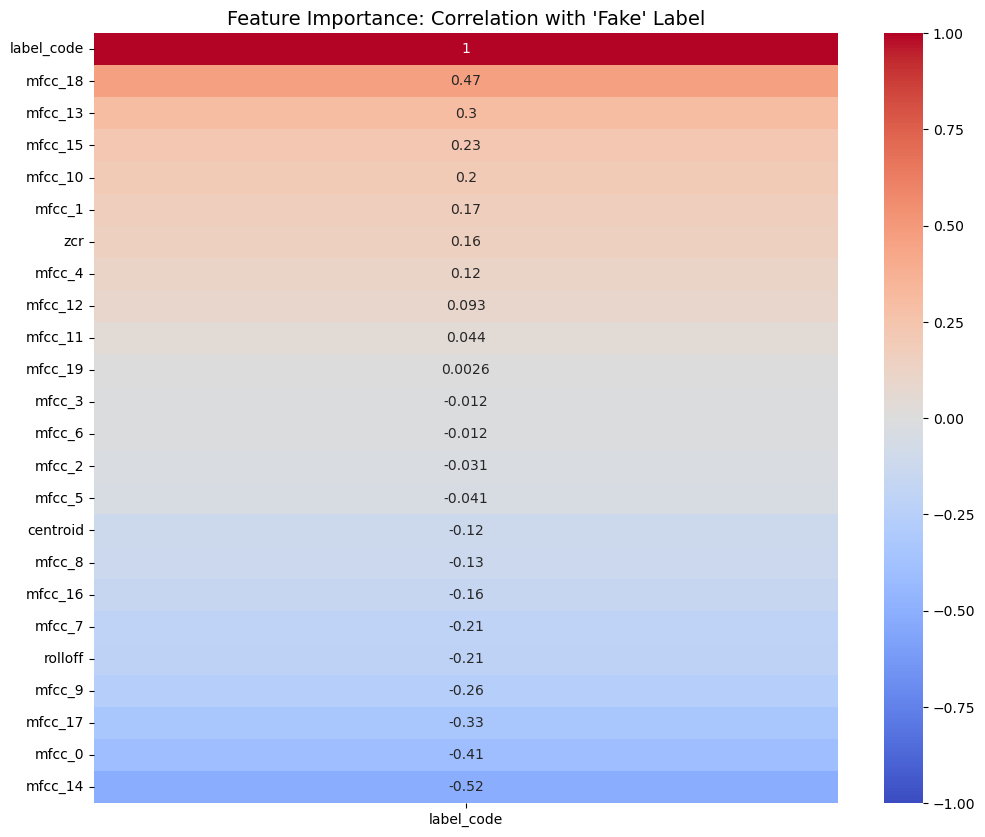

In [30]:
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
corr = numeric_df.corr()
sns.heatmap(corr[['label_code']].sort_values(by='label_code', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Importance: Correlation with 'Fake' Label", fontsize=14)
plt.show()

Train Test Split

In [9]:
X = df.drop(columns=['file', 'label', 'label_code'])
y = df['label_code']

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
models = {
        'Logistic Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(random_state=42, max_iter=1000))
        ]),
        'Decision Tree': Pipeline([
            ('scaler', StandardScaler()), # Scaler is optional for Trees but good for pipelines
            ('model', DecisionTreeClassifier(random_state=42, max_depth=5)) 
        ])
    }

In [18]:
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=42, max_iter=1000))
    ])

In [19]:

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)
acc = accuracy_score(y_test, preds)
print(f"Accuracy: {acc*100:.2f}%")
print(classification_report(y_test, preds, target_names=['Real (0)', 'Fake (1)']))


Accuracy: 93.16%
              precision    recall  f1-score   support

    Real (0)       0.93      0.96      0.95      3950
    Fake (1)       0.93      0.88      0.91      2406

    accuracy                           0.93      6356
   macro avg       0.93      0.92      0.93      6356
weighted avg       0.93      0.93      0.93      6356



In [21]:
with open("deepfake_model_lr.pkl", "wb") as f:
    pickle.dump(pipeline, f)
        
print("Model saved as 'deepfake_model_lr.pkl' using pickle.")

Model saved as 'deepfake_model_lr.pkl' using pickle.


2.3.5
2.3.3
1.7.2
0.11.0
